In [88]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import os
import cv2
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../")
from per_segment_anything import sam_model_registry, SamPredictor

In [89]:
from IPython.display import display, Image

In [90]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [91]:
ref_folder_path = "ref_pd"
images_folder_path = "test_pd"
output_path = 'outputs_pd'
ext = "jpg"

os.makedirs(output_path, exist_ok=True)

In [92]:
lr = 1e-3
train_epoch = 1000
log_epoch = 200
sam_type = "vit_h"

In [93]:
print("======> Load SAM" )
if sam_type == 'vit_h':
    sam_type, sam_ckpt = 'vit_h', '../sam/sam_vit_h.pth'
    sam = sam_model_registry[sam_type](checkpoint=sam_ckpt).cuda()
elif sam_type == 'vit_t':
    sam_type, sam_ckpt = 'vit_t', 'weights/mobile_sam.pt'
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry[sam_type](checkpoint=sam_ckpt).to(device=device)
    sam.eval()


for name, param in sam.named_parameters():
    param.requires_grad = False
predictor = SamPredictor(sam)

======> Load SAM


In [94]:
print("\n------------> Segment ")
    
# Path preparation
ref_image_path = os.path.join(ref_folder_path, f'original.{ext}')
ref_mask_path = os.path.join(ref_folder_path, f'mask.{ext}')
test_images_path = images_folder_path

# Load images and masks
ref_image = cv2.imread(ref_image_path)
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
# ref_image = cv2.resize(ref_image,None,fx=0.1,fy=0.1)

ref_mask = cv2.imread(ref_mask_path)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2RGB)
# ref_mask = cv2.resize(ref_mask,None,fx=0.1,fy=0.1)

gt_mask = torch.tensor(ref_mask)[:, :, 0] > 0 
gt_mask = gt_mask.float().unsqueeze(0).flatten(1).cuda()


------------> Segment 


In [95]:
print("======> Obtain Self Location Prior" )
# Image features encoding
print(ref_image.shape, ref_mask.shape)
ref_mask = predictor.set_image(ref_image, ref_mask)
print(ref_mask.shape)
ref_feat = predictor.features.squeeze().permute(1, 2, 0)
print(ref_feat.shape)
ref_mask = F.interpolate(ref_mask, size=ref_feat.shape[0: 2], mode="bilinear")
ref_mask = ref_mask.squeeze()[0]
print(ref_mask.shape)

# Target feature extraction
target_feat = ref_feat[ref_mask > 0]
target_feat_mean = target_feat.mean(0)
target_feat_max = torch.max(target_feat, dim=0)[0]
target_feat = (target_feat_max / 2 + target_feat_mean / 2).unsqueeze(0)

# Cosine similarity
h, w, C = ref_feat.shape
target_feat = target_feat / target_feat.norm(dim=-1, keepdim=True)
ref_feat = ref_feat / ref_feat.norm(dim=-1, keepdim=True)
ref_feat = ref_feat.permute(2, 0, 1).reshape(C, h * w)
sim = target_feat @ ref_feat

sim = sim.reshape(1, 1, h, w)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
sim = predictor.model.postprocess_masks(
                sim,
                input_size=predictor.input_size,
                original_size=predictor.original_size).squeeze()

======> Obtain Self Location Prior
(480, 640, 3) (480, 640, 3)
torch.Size([1, 3, 1024, 1024])
torch.Size([64, 64, 256])
torch.Size([64, 64])


In [59]:
def sim_to_heatmap(sim):
    if torch.is_tensor(sim):
        x = sim.to("cpu").detach().numpy().copy()
    else:
        x = sim.copy()
    h, w = x.shape
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    x = (x * 255).reshape(-1)
    cm = plt.get_cmap("jet")
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return (x * 255).astype(np.uint8).reshape(h, w, 3)

In [ ]:
print('======> Start Testing')

# Load test image
# file_name = 'image_almi'
file_name = 'positon_detector_original'
test_image_path = os.path.join(test_images_path, f"{file_name}.{ext}" )
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Image feature encoding
predictor.set_image(test_image)
test_feat = predictor.features.squeeze()

# Cosine similarity
C, h, w = test_feat.shape
test_feat = test_feat / test_feat.norm(dim=0, keepdim=True)
test_feat = test_feat.reshape(C, h * w)
sim = target_feat @ test_feat

sim = sim.reshape(1, 1, h, w)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
sim = predictor.model.postprocess_masks(
                sim,
                input_size=predictor.input_size,
                original_size=predictor.original_size).squeeze()


======> Start Testing
64 64


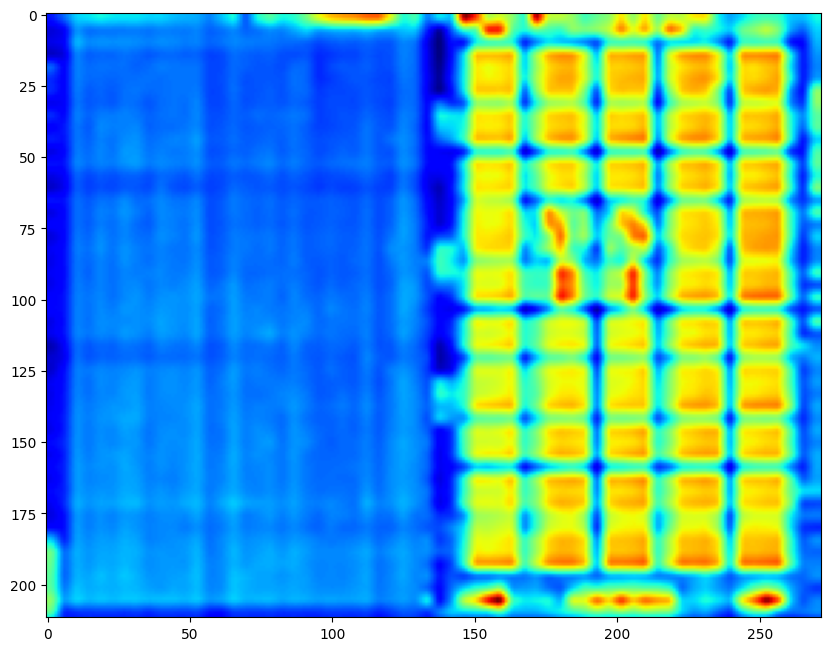

In [61]:
heat_map = sim_to_heatmap(sim)
plt.figure(figsize=(10,10))
plt.imshow(heat_map)
plt.axis('on')
plt.show()  